<a href="https://colab.research.google.com/github/KHANmdAFFAN/Data_science/blob/main/spotify_system_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Description 

##Spotify Playlist Recommendation System

### Description of the Project
The goal of the challenge is to develop a system for the task of automatic playlist continuation. given a set of playlist features, participants' systems shall generate a list of recommended tracks that can be added to that playlist, thereby "continuing" the playlist ```


### Overall flow of the project
the data is structured in arrays that typically contain 1,000 playlists. each playlist is a dictionary that contains the following fields:[]




 * pid - integer - playlist id - the mpd id of this playlist. this is an integer between 0 and 999,999.
 
 * name - string - the name of the playlist
 
 * description - optional string - if present, the description given to the playlist. note that user-provided playlist descriptions are a relatively new feature of spotify, so most playlists do not have descriptions.
 
 * modified_at - seconds - timestamp (in seconds since the epoch) when this playlist was last updated. times are rounded to midnight gmt of the date when the playlist was last updated.
 
 * num_artists - the total number of unique artists for the tracks in the playlist.
 
 * num_albums - the number of unique albums for the tracks in the playlist 
 
 *num_tracks - the number of tracks in the playlist
 
 * num_followers - the number of followers this playlist had at the time the mpd was created. (note that the follower count does not including the playlist creator) 
 
 *num_edits - the number of separate editing sessions.Tracks added in a two hour window are considered to be added in a single editing session.

 *duration_ms - the total duration of all the tracks in the playlist (in milliseconds) 
 
 *collaborative - boolean - if true, the playlist is a collaborative playlist. multiple users may contribute tracks to a collaborative playlist.
 
 * tracks - an array of information about each track in the playlist. each element in the array is a dictionary with the following fields:

In [ ]:
#* track_name - the name of the track 
#* track_uri - the spotify uri of the track
#* album_name - the name of the track's album 
#* album_uri - the spotify uri of the album 
#* artist_name - the name of the track's primary artist 
#* artist_uri - the spotify uri of track's primary artist 
#* duration_ms - the duration of the track in milliseconds 
#* pos - the position of the track in the playlist (zero-based)

In [ ]:

import json as json
import re
import sys
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import pandas as pd #data manpulation
import numpy as np
import matplotlib.pyplot as plt #data visualization
import seaborn as sns
import scipy

# 1) Cleaning + EDA + Standarization + Encoding 
import chardet #to detetmine dataset encoding

from sklearn.preprocessing import StandardScaler # scaling data so mean = 0 and std =  1 by ((x- u) / std)
from scipy import stats # for Box-Cox Transformation stats.boxcox(original_data)[0]
from mlxtend.preprocessing import minmax_scaling # for min_max scaling dont use it
#or
from sklearn.preprocessing import MinMaxScaler,normalize  #Tune input range to be 0 -> 1 by MinMaxScaler, same as above

#preprocessing: replace numeric and categorical
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder # label (ordinal or nominal)
from sklearn.preprocessing import OrdinalEncoder # object (no order)
from sklearn.preprocessing import OneHotEncoder # categorical 

# 2) feature enginerring
from sklearn.feature_selection import mutual_info_regression #mutal importance of feature
# a) numeric feature enginering
from sklearn.cluster import KMeans # Kmeans model for cluster feature
from IPython.display import display
from sklearn.decomposition import PCA # for loadings and adding new feature

#pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import time



## **Data Prepration Phase**

In this phase we needed to flatten our data

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data1 = json.load(open('/content/drive/MyDrive/Spotify_Playlist_Datasets.rar (Unzipped Files)/mpd.slice.0-999.json'))
data2 = json.load(open('/content/drive/MyDrive/Spotify_Playlist_Datasets.rar (Unzipped Files)/mpd.slice.1000-1999.json'))
data3 = json.load(open('/content/drive/MyDrive/Spotify_Playlist_Datasets.rar (Unzipped Files)/mpd.slice.2000-2999.json'))
data4 = json.load(open('/content/drive/MyDrive/Spotify_Playlist_Datasets.rar (Unzipped Files)/mpd.slice.3000-3999.json'))

df1= pd.DataFrame(data1['playlists'])
df2= pd.DataFrame(data2['playlists'])
df3= pd.DataFrame(data3['playlists'])
df4= pd.DataFrame(data4['playlists'])

df = pd.concat([df1,df2,df3,df4])

df= df.explode('tracks')
df= pd.concat([df.drop(['tracks'], axis=1), df['tracks'].apply(pd.Series)],axis=1)

# renaming the columns with the same name 
df.columns=['name', 'collaborative', 'pid', 'modified_at', 'num_tracks', 'num_albums', 'num_followers', 'num_edits', 'playlist_duration_ms', 'num_artists', 'description', 'pos', 'artist_name', 'track_uri', 'artist_uri', 'track_name', 'album_uri', 'track_duration_ms', 'album_name']

And we have data ready to manipulate it :


## the current features are not enough to analyze the tracks so it's needed to extract more features from tracks uri

### from above there are some features have uri in names , after searching i found this:

A spotify uri (uniform resource indicator) is a link that you can find in the share menu of any track, album, or artist profile on spotify.

When you click a link that consists of a spotify uri (rather than an http address), you're taken directly to the spotify application, without having to go through the web page first.


## it could be used and extract more data by api spotipy ,but i already have the name of the track , artist and album in the dataset so i'm gonna take a copy of dataframe and remove the uri features before making any process

In [ ]:
#extract uri 
df['track_uri']= df["track_uri"].apply(lambda x: re.findall(r'\w+$', str(x))[0])

In [ ]:
df.head()

,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,num_edits,playlist_duration_ms,num_artists,description,pos,artist_name,track_uri,artist_uri,track_name,album_uri,track_duration_ms,album_name
0,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,NaN,0,Missy Elliott,0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook
0,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,NaN,1,Britney Spears,6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Toxic,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800,In The Zone
0,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,NaN,2,Beyoncé,0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Crazy In Love,spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,Dangerously In Love (Alben für die Ewigkeit)
0,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,NaN,3,Justin Timberlake,1AWQoqb9bSvzTjaLralEkT,spotify:artist:31TPClRtHm23RisEBtV3X7,Rock Your Body,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266,Justified
0,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,NaN,4,Shaggy,1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,It Wasn't Me,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,Hot Shot


In [ ]:

df.tail()

,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,num_edits,playlist_duration_ms,num_artists,description,pos,artist_name,track_uri,artist_uri,track_name,album_uri,track_duration_ms,album_name
999,other,false,3999,1420848000,97,56,1,9,22548683,17,NaN,92,Alanis Morissette,7c1iI6dwdCpHGYT8DGEfab,spotify:artist:6ogn9necmbUdCppmNnGOdi,Uninvited,spotify:album:4N7LuZYpstQrtcHIoOKzqg,276200,The Collection
999,other,false,3999,1420848000,97,56,1,9,22548683,17,NaN,93,Alanis Morissette,4l7YIni9bAiGwWMqK5wvgV,spotify:artist:6ogn9necmbUdCppmNnGOdi,You Learn - 2015 Remastered,spotify:album:5Ap3F8CxjjsQKZGASDcHNA,239640,Jagged Little Pill (Remastered)
999,other,false,3999,1420848000,97,56,1,9,22548683,17,NaN,94,Alanis Morissette,2LVxvGhl2U5p2ql2ujc6vZ,spotify:artist:6ogn9necmbUdCppmNnGOdi,Hands Clean,spotify:album:0kKfmdca8GY7bDWFWtY801,269400,Under Rug Swept
999,other,false,3999,1420848000,97,56,1,9,22548683,17,NaN,95,Andrew McMahon in the Wilderness,2Kgjd9G808FhUDRhS2gidG,spotify:artist:716ZwtZBmwROBXcFmCzfdM,Cecilia And The Satellite,spotify:album:1FtH1WWaGL1OvhTMAMw5XI,223879,Andrew McMahon In The Wilderness
999,other,false,3999,1420848000,97,56,1,9,22548683,17,NaN,96,Michelle Branch,1u0l8zWpQeMYStFkc2mLD7,spotify:artist:5rScKX1Sh1U67meeUyTGwk,Everywhere,spotify:album:1agL7TUoZXr0Xd4Irievqi,214826,The Spirit Room


In [ ]:
! pip install spotipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 246 kB 59.3 MB/s 
     |████████████████████████████████| 140 kB 70.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
# imports for API
import spotipy # Web App API
import spotipy.oauth2 as oauth2
from spotipy.oauth2 import SpotifyOAuth
from spotipy.oauth2 import SpotifyClientCredentials

In [ ]:
# client key = fbe8496c96c94607994ce558ef17ac01
# secret key = b185f8ccd1104d06a174aa42ea9420fa
auth_manger = SpotifyClientCredentials(client_id= '2d94d5f70296490aa807220f93b142fb', client_secret= '5882d3134d2b4a448c0547618e6572e4')


In [ ]:
# Artist info
sp = spotipy.Spotify(auth_manager=auth_manger) # API
artist_info = 'https://open.spotify.com/artist/26dSoYclwsYLMAKD3tpOr4?si=3rSxDEx7SIGPdo6Q7jOv6Q'
artist = sp.artist(artist_info)
artist

{'external_urls': {'spotify': 'https://open.spotify.com/artist/26dSoYclwsYLMAKD3tpOr4'},
 'followers': {'href': None, 'total': 11271496},
 'genres': ['dance pop', 'pop', 'post-teen pop'],
 'href': 'https://api.spotify.com/v1/artists/26dSoYclwsYLMAKD3tpOr4',
 'id': '26dSoYclwsYLMAKD3tpOr4',
 'images': [{'height': 640,
   'url': 'https://i.scdn.co/image/ab6761610000e5eb4e7e6ded87a4e0f65b5afcec',
   'width': 640},
  {'height': 320,
   'url': 'https://i.scdn.co/image/ab676161000051744e7e6ded87a4e0f65b5afcec',
   'width': 320},
  {'height': 160,
   'url': 'https://i.scdn.co/image/ab6761610000f1784e7e6ded87a4e0f65b5afcec',
   'width': 160}],
 'name': 'Britney Spears',
 'popularity': 81,
 'type': 'artist',
 'uri': 'spotify:artist:26dSoYclwsYLMAKD3tpOr4'}

In [ ]:

# All albums of an artist

# from spotipy import Spotify as spotify
results = sp.artist_albums(artist_info, album_type='album') # return first album of this artist and pointer to next album
albums = results['items'] #array of tracks in first album
print('number of tracks in first album is ', len(albums)) # number of tracks in album
while results['next']:
    results = spotify.next(results) # to access next album
    albums.extend(results['items'])

for album in albums:
    print(album['name'])

number of tracks in first album is  15
Glory (Deluxe)
Glory (Deluxe)
Glory : Japan Tour Edition
Glory (Japan Deluxe Version)
Glory (Deluxe Version)
Glory (Deluxe Version)
Britney Jean (Deluxe Version)
Britney Jean (Deluxe Version)
Femme Fatale (Deluxe Version)
Circus (Deluxe Version)
Blackout
In The Zone
Britney (Digital Deluxe Version)
Oops!... I Did It Again
...Baby One More Time (Digital Deluxe Version)


## Audio Analysis of tracks

In [ ]:
# All country codes
print(sp.country_codes )

['AD', 'AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DK', 'DO', 'EC', 'SV', 'EE', 'FI', 'FR', 'DE', 'GR', 'GT', 'HN', 'HK', 'HU', 'IS', 'ID', 'IE', 'IT', 'JP', 'LV', 'LI', 'LT', 'LU', 'MY', 'MT', 'MX', 'MC', 'NL', 'NZ', 'NI', 'NO', 'PA', 'PY', 'PE', 'PH', 'PL', 'PT', 'SG', 'ES', 'SK', 'SE', 'CH', 'TW', 'TR', 'GB', 'US', 'UY']


In [ ]:
# Top 5 Tracks for an Artist
results = sp.artist_top_tracks(artist_info, country='US')

for track in results['tracks'][:5]: #0->4
    print('Track     :', track['name'])
    print('Audio     :', track['preview_url'])
    print('Cover Art :', track['album']['images'][0]['url'])
    print()

Track     : Hold Me Closer
Audio     : None
Cover Art : https://i.scdn.co/image/ab67616d0000b273775800e93752168c8004b59f

Track     : Toxic
Audio     : https://p.scdn.co/mp3-preview/7e3699a5a8b20b5847234627839a1c68bfaf5fb4?cid=2d94d5f70296490aa807220f93b142fb
Cover Art : https://i.scdn.co/image/ab67616d0000b273efc6988972cb04105f002cd4

Track     : Gimme More
Audio     : https://p.scdn.co/mp3-preview/759be80fb1378fd49f6c7ad48c3513c05c53a7d7?cid=2d94d5f70296490aa807220f93b142fb
Cover Art : https://i.scdn.co/image/ab67616d0000b273ca10fae7d292c52f7e8b11ca

Track     : ...Baby One More Time
Audio     : https://p.scdn.co/mp3-preview/fd353f288358cb29fa0628254152ec6aab2ee99c?cid=2d94d5f70296490aa807220f93b142fb
Cover Art : https://i.scdn.co/image/ab67616d0000b2738e49866860c25afffe2f1a02

Track     : Oops!...I Did It Again
Audio     : https://p.scdn.co/mp3-preview/52bb73e57b05641dd4ce1f444c135a1b5f145b66?cid=2d94d5f70296490aa807220f93b142fb
Cover Art : https://i.scdn.co/image/ab67616d0000b2732a

In [ ]:
list(df['track_uri'][0])[0]

'0UaMYEvWZi0ZqiDOoHU3YI'

In [ ]:
# Track Features
sp.audio_features(list(df['track_uri'][0])[0])

[{'danceability': 0.904,
  'energy': 0.813,
  'key': 4,
  'loudness': -7.105,
  'mode': 0,
  'speechiness': 0.121,
  'acousticness': 0.0311,
  'instrumentalness': 0.00697,
  'liveness': 0.0471,
  'valence': 0.81,
  'tempo': 125.461,
  'type': 'audio_features',
  'id': '0UaMYEvWZi0ZqiDOoHU3YI',
  'uri': 'spotify:track:0UaMYEvWZi0ZqiDOoHU3YI',
  'track_href': 'https://api.spotify.com/v1/tracks/0UaMYEvWZi0ZqiDOoHU3YI',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/0UaMYEvWZi0ZqiDOoHU3YI',
  'duration_ms': 226864,
  'time_signature': 4}]

In [ ]:
track_info = sp.track('0UaMYEvWZi0ZqiDOoHU3YI') # Track info
track_features = sp.audio_features('0UaMYEvWZi0ZqiDOoHU3YI') # Track Features

name = track_info['name'] #track name
album = track_info['album']['name'] #album details
artist = track_info['album']['artists'][0]['name']
release_date = track_info['album']['release_date']
length = track_info['duration_ms']
popularity = track_info['popularity']

acousticness = track_features[0]['acousticness']
danceability = track_features[0]['danceability']
energy = track_features[0]['energy']
instrumentalness = track_features[0]['instrumentalness']
liveness = track_features[0]['liveness']
loudness = track_features[0]['loudness']
speechiness = track_features[0]['speechiness']
tempo = track_features[0]['tempo']
time_signature = track_features[0]['time_signature']

track = [name,
album,
artist,
release_date,
length,
popularity,
acousticness,
danceability,
energy,
instrumentalness,
liveness,
loudness,
speechiness,
tempo,
time_signature]

track

['Lose Control (feat. Ciara & Fat Man Scoop)',
 'The Cookbook',
 'Missy Elliott',
 '2005-07-04',
 226863,
 67,
 0.0311,
 0.904,
 0.813,
 0.00697,
 0.0471,
 -7.105,
 0.121,
 125.461,
 4]

In [ ]:
one_track = pd.DataFrame(track).T.values.tolist()
columns = ['Name', 'Album', 'Artist', 'Release_date', 'Length', 'Popularity', 'Acousticness', 'Danceability', 'Energy', 'Instrumentalness', 'Liveness', 'Loudness', 'Speechiness', 'Tempo', 'Time_signature']
df_final = pd.DataFrame(one_track, columns=columns)
df_final

,Name,Album,Artist,Release_date,Length,Popularity,Acousticness,Danceability,Energy,Instrumentalness,Liveness,Loudness,Speechiness,Tempo,Time_signature
0,Lose Control (feat. Ciara & Fat Man Scoop),The Cookbook,Missy Elliott,2005-07-04,226863,67,0.0311,0.904,0.813,0.00697,0.0471,-7.105,0.121,125.461,4


## 1> chose a playlist that contains tracks and get their ids

In [ ]:
def getTrackIDs(user, playlist_id): # get all track ids of specific playlist
    track_ids = []
    playlist = sp.user_playlist(user, playlist_id)
    for item in playlist['tracks']['items']:
        track = item['track']
        track_ids.append(track['id'])
    return track_ids

In [ ]:
track_ids = getTrackIDs('spotify', '0P9T607jwhVujYSs14oXNJ') # 0P9T607jwhVujYSs14oXNJ is sao playlist
print(len(track_ids))
print(track_ids)

9
['3mScGCzxiXA9OaHdBeuk7O', '4P72GmIjFjP90tIKhHeLQz', '6vANutLeXwwAegl7PUWCGw', '4Tb3EXAUbgC7YUyJQORL9G', '3SeTLr7u3ktxAnudJ5UpbD', '3cxWQQAN1WDxPisYoG6hA4', '2OBQ5aQ1KBsjuxJvThlBl6', '5Z15dtbuDwcug9PDA7g0v4', '5PEUBHCoNu8c1FC6sVdaK2']


In [ ]:
def getTrackFeatures(id):
    track_info = sp.track(id) # Track info
    track_features = sp.audio_features(id) # Track Features

    name = track_info['name'] #track name
    album = track_info['album']['name'] #album details
    artist = track_info['album']['artists'][0]['name']
    release_date = track_info['album']['release_date']
    length = track_info['duration_ms']
    popularity = track_info['popularity']

    acousticness = track_features[0]['acousticness']
    danceability = track_features[0]['danceability']
    energy = track_features[0]['energy']
    instrumentalness = track_features[0]['instrumentalness']
    liveness = track_features[0]['liveness']
    loudness = track_features[0]['loudness']
    speechiness = track_features[0]['speechiness']
    tempo = track_features[0]['tempo']
    time_signature = track_features[0]['time_signature']

    track = [name,
    album,
    artist,
    release_date,
    length,
    popularity,
    acousticness,
    danceability,
    energy,
    instrumentalness,
    liveness,
    loudness,
    speechiness,
    tempo,
    time_signature]
    
    return track

In [ ]:
# get tracks info
track_list = []
for i in range(len(track_ids)):
    time.sleep(0.3) # 0.3 seconds to prevent many requests at same time
    track_data = getTrackFeatures(track_ids[i])
    track_list.append(track_data)

df_new = pd.DataFrame(track_list, columns=columns)
df_new

,Name,Album,Artist,Release_date,Length,Popularity,Acousticness,Danceability,Energy,Instrumentalness,Liveness,Loudness,Speechiness,Tempo,Time_signature
0,crossing field,LANDSPACE,LiSA,2013-10-30,248946,13,0.015700,0.447,0.983,0.000000,0.276,-2.281,0.2680,179.072,4
1,crossing field -English ver.-,Shirushi,LiSA,2014-12-10,248600,0,0.076500,0.411,0.970,0.000000,0.341,-2.442,0.2860,179.102,4
2,Crossing Field,Crossing Field,The Unknown Songbird,2018-03-19,245368,19,0.012100,0.496,0.714,0.000002,0.124,-7.578,0.0567,178.869,4
3,"Crossing Field (From ""Sword Art Online"")","Crossing Field (From ""Sword Art Online"")",NateWantsToBattle,2021-06-12,243519,0,0.000927,0.471,0.955,0.000000,0.334,-5.456,0.1290,178.952,4
4,"Crossing Field (From ""Sword Art Online"")",Link Start,AmaLee,2016-03-30,245027,0,0.002890,0.387,0.917,0.000000,0.125,-4.276,0.2350,178.990,4
5,Crossing Fields,Crossing Fields,Alive in the Dark,2016-11-25,243168,14,0.000063,0.250,0.849,0.000004,0.357,-4.847,0.0537,180.086,4
6,"Crossing Field (From ""Sword Art Online"") [Open...","Anime Piano Music Collection in Spring, Vol. 3",Fonzi M,2019-04-13,248965,0,0.948000,0.513,0.378,0.944000,0.121,-16.195,0.0300,89.483,4
7,Crossing Field (Sword Art Online),"Mattyyym Does Anime!, Vol. 2",Mattyyym,2017-10-25,91343,14,0.000016,0.239,0.692,0.754000,0.128,-6.995,0.0403,178.952,4
8,"Crossing Field (From ""Sword Art Online"")","Ru's Piano Anime Collection, Vol. 1",Ru's Piano,2021-01-21,239400,22,0.969000,0.448,0.389,0.830000,0.140,-12.961,0.0334,91.433,4


In [ ]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              9 non-null      object 
 1   Album             9 non-null      object 
 2   Artist            9 non-null      object 
 3   Release_date      9 non-null      object 
 4   Length            9 non-null      int64  
 5   Popularity        9 non-null      int64  
 6   Acousticness      9 non-null      float64
 7   Danceability      9 non-null      float64
 8   Energy            9 non-null      float64
 9   Instrumentalness  9 non-null      float64
 10  Liveness          9 non-null      float64
 11  Loudness          9 non-null      float64
 12  Speechiness       9 non-null      float64
 13  Tempo             9 non-null      float64
 14  Time_signature    9 non-null      int64  
dtypes: float64(8), int64(3), object(4)
memory usage: 1.2+ KB


## EDA

In [ ]:
df_new.Artist.value_counts()

LiSA                    2
The Unknown Songbird    1
NateWantsToBattle       1
AmaLee                  1
Alive in the Dark       1
Fonzi M                 1
Mattyyym                1
Ru's Piano              1
Name: Artist, dtype: int64

In [ ]:
df_new.columns

Index(['Name', 'Album', 'Artist', 'Release_date', 'Length', 'Popularity',
       'Acousticness', 'Danceability', 'Energy', 'Instrumentalness',
       'Liveness', 'Loudness', 'Speechiness', 'Tempo', 'Time_signature'],
      dtype='object')

In [ ]:
import plotly.express as px
fig = px.scatter(df_new, x=df_new['Tempo'], y=df_new['Danceability'], color=df_new['Popularity'], size=df_new['Popularity'], title='Song popularity')
fig.show()

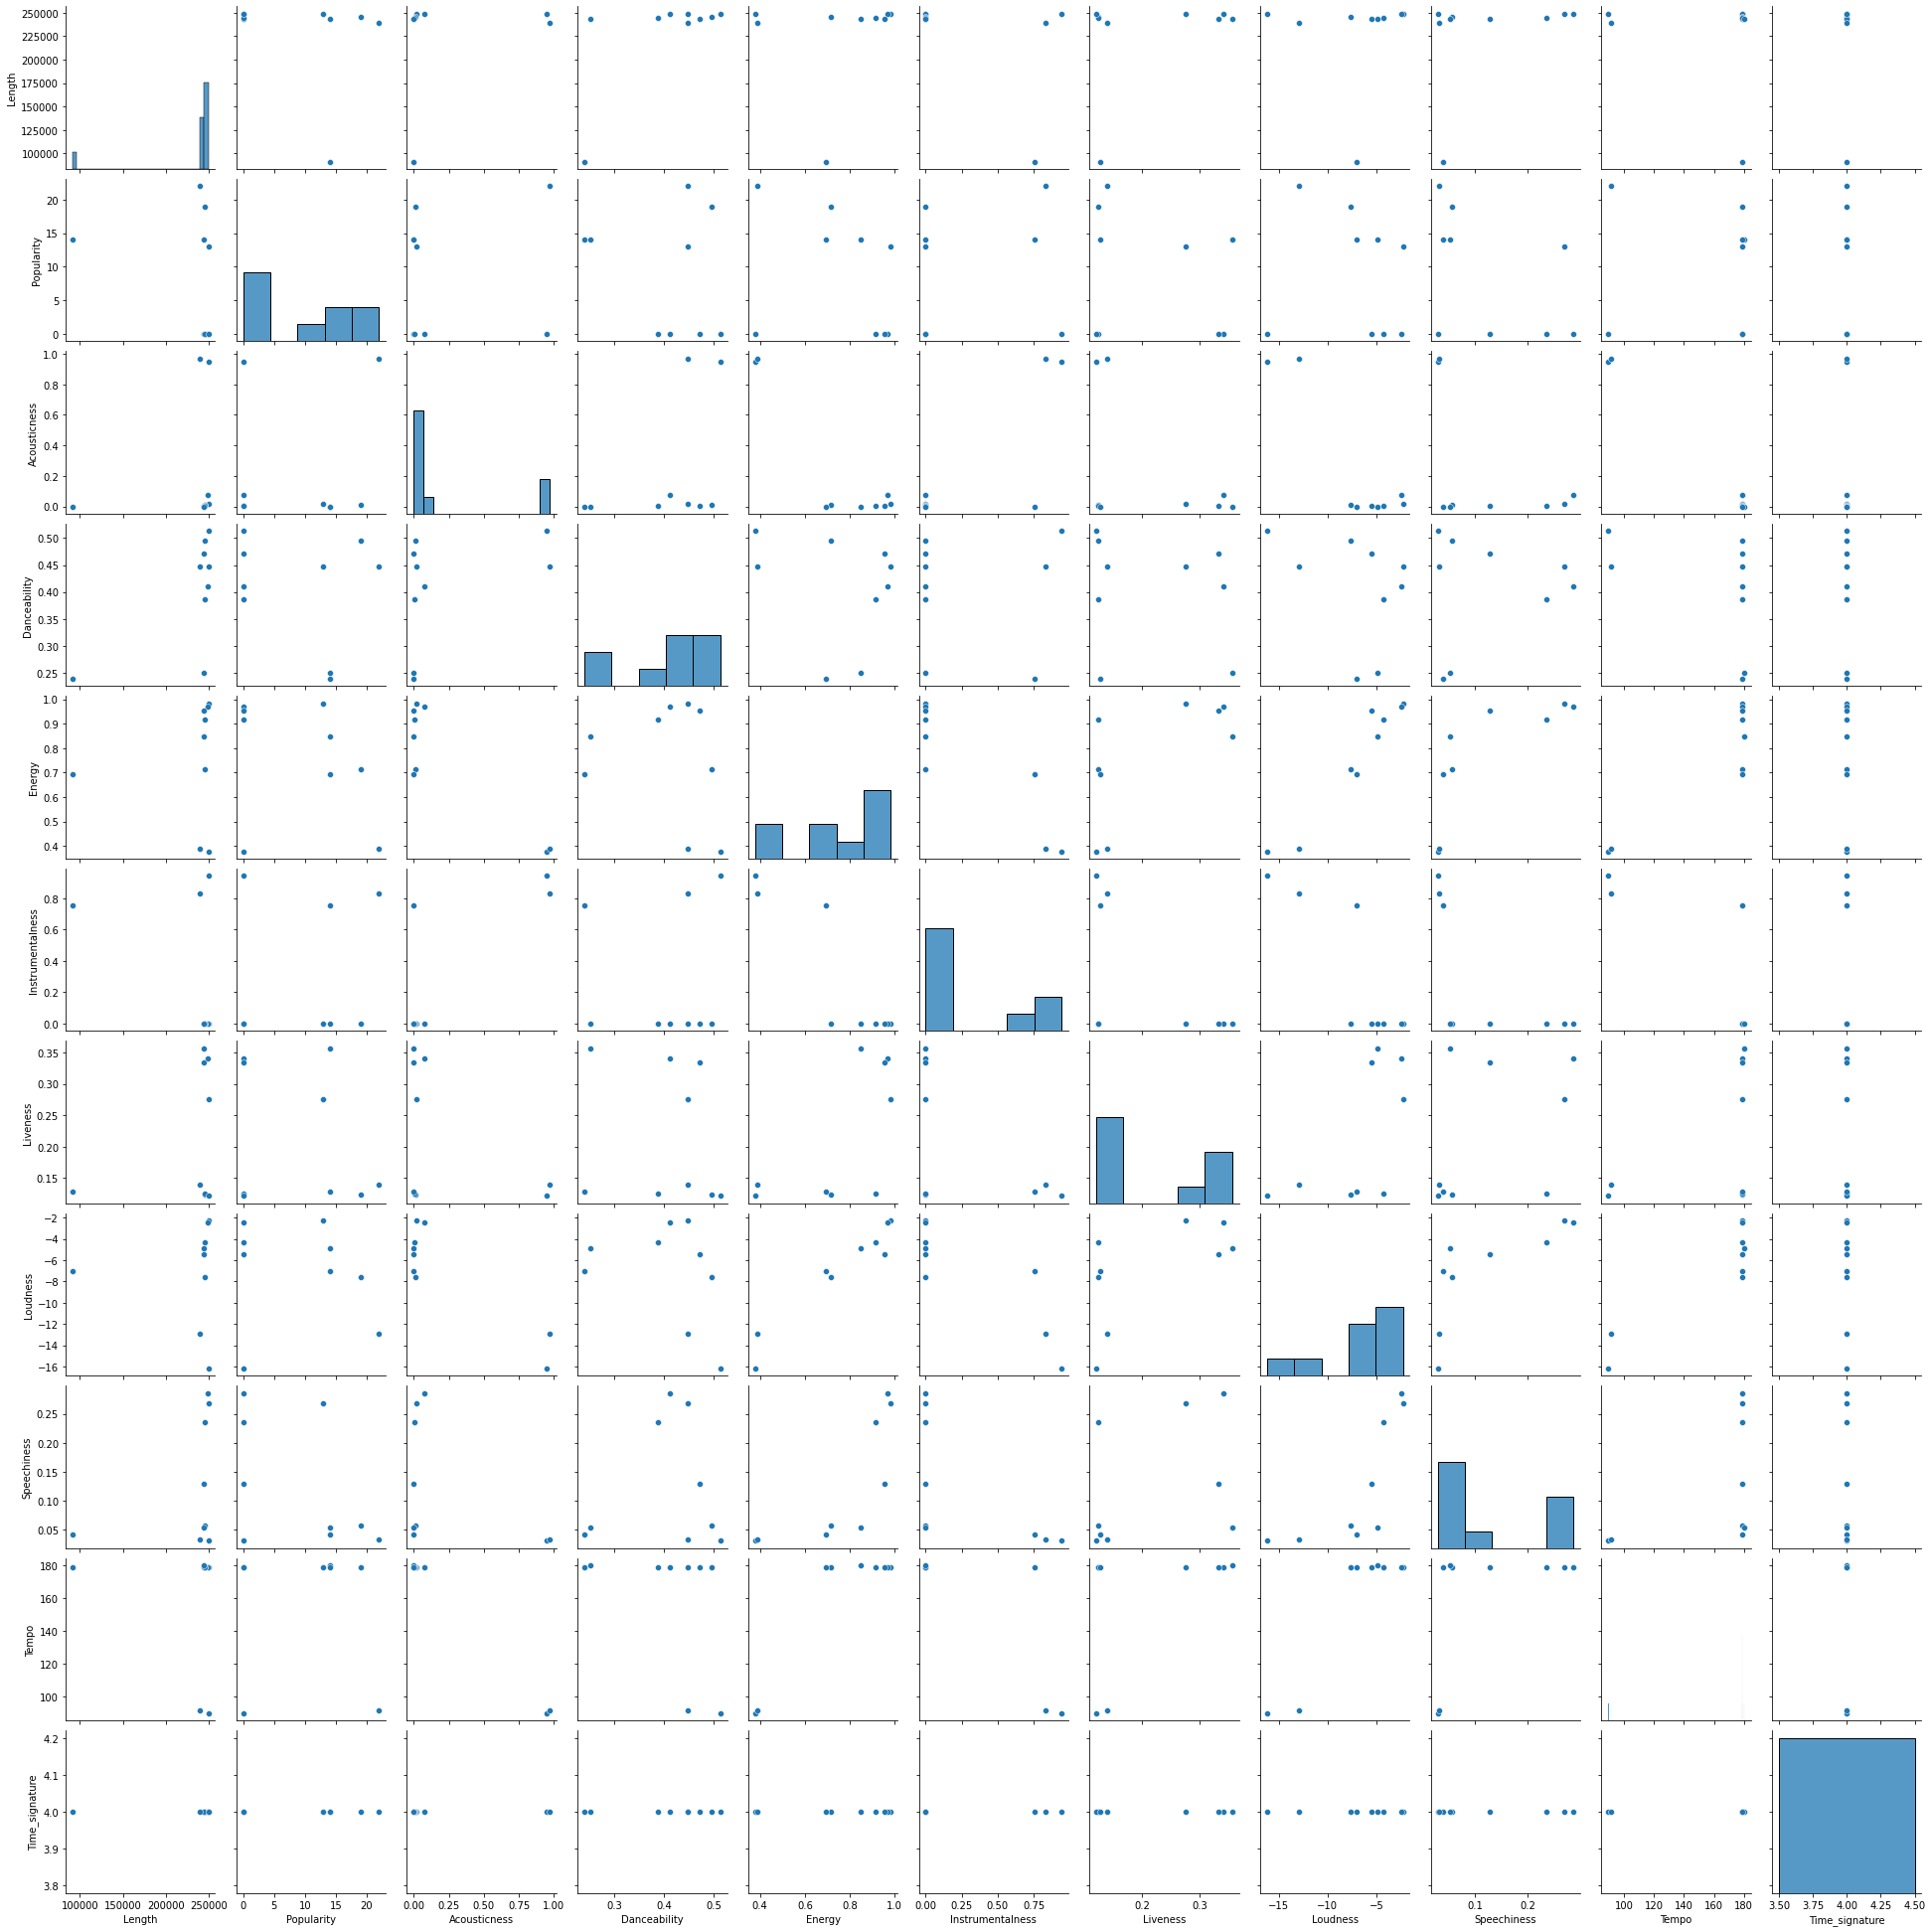

In [ ]:
sns.pairplot(df_new)
plt.show()